In [124]:
# Ensure plots show inline

%matplotlib inline



import cv2

import os

from matplotlib import pyplot as plt

import numpy as np



# -----------------------------

# Helper functions

# -----------------------------



def to_grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)





def denoise(img):

    """

    Light denoising while preserving edges.

    """

    return cv2.fastNlMeansDenoising(img, h=4)





import cv2
import numpy as np

def segment(img, min_piece_size=350):
    """
    Segment the input grayscale image into puzzle pieces.
    
    Parameters:
        img: Grayscale input image
        min_piece_size: Minimum pixel area to keep (removes small internal noise)
    
    Returns:
        filtered_mask: Cleaned binary mask
        contours: Contours of each puzzle piece
    """
    # 1. Slight smoothing to remove tiny pixel noise without losing edges
    blurred = cv2.GaussianBlur(img, (3, 3), 0)

    # 2. Adaptive threshold to preserve internal variations
    thresh = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,  # size of neighborhood
        C=2
    )

    # 3. Morphology: remove tiny noise, minimal closing to preserve details
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 4. Connected component filtering to remove small internal noise
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean, connectivity=8)
    filtered_mask = np.zeros_like(clean)

    for i in range(1, num_labels):  # skip background
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_piece_size:
            filtered_mask[labels == i] = 255

    # 5. Optional: small close to fill tiny gaps inside pieces
    filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 6. Find contours of the filtered mask
    contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return filtered_mask, contours









def draw_contours(img):

    """

    Draw simplified contours (less detail, smoother borders).

    """

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)



    simplified_contours = []

    for cnt in contours:

        # epsilon controls smoothness (higher = smoother)

        epsilon = 0.015 * cv2.arcLength(cnt, True)

        approx = cv2.approxPolyDP(cnt, epsilon, True)

        simplified_contours.append(approx)



    cv2.drawContours(img_copy, simplified_contours, -1, (0, 255, 0), 2)

    return img_copy





def detect_edges(img, low_threshold=50, high_threshold=150, aperture_size=5):

    """

    Edge detection using Canny.

    """

    edges = cv2.Canny(img, low_threshold, high_threshold, apertureSize=aperture_size)

    return edges





def show_images(images, titles):

    """

    Display multiple images in a row.

    """

    plt.figure(figsize=(15, 5))

    for i, (img, title) in enumerate(zip(images, titles)):

        plt.subplot(1, len(images), i + 1)

        if len(img.shape) == 2:  # grayscale

            plt.imshow(img, cmap="gray")

        else:

            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.title(title)

        plt.axis("off")

    plt.show()





# display limits for previews

display_limit = 5

display_count = 0

In [125]:
# Input folder (original puzzle images)
puzzle_folder = r"C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset\Gravity Falls\puzzle_2x2"

# Output folder (processed results)
output_folder = r"C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset\results\results_2x2"
os.makedirs(output_folder, exist_ok=True)

# List PNG files
files = [f for f in os.listdir(puzzle_folder) if f.endswith(".jpg") or f.endswith(".png")]
print(f"Found {len(files)} images in {puzzle_folder}")


Found 110 images in C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset\Gravity Falls\puzzle_2x2


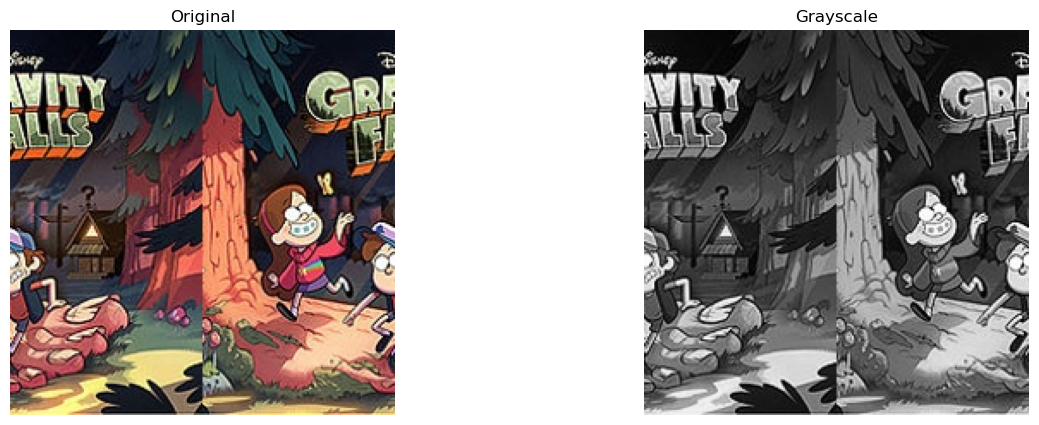

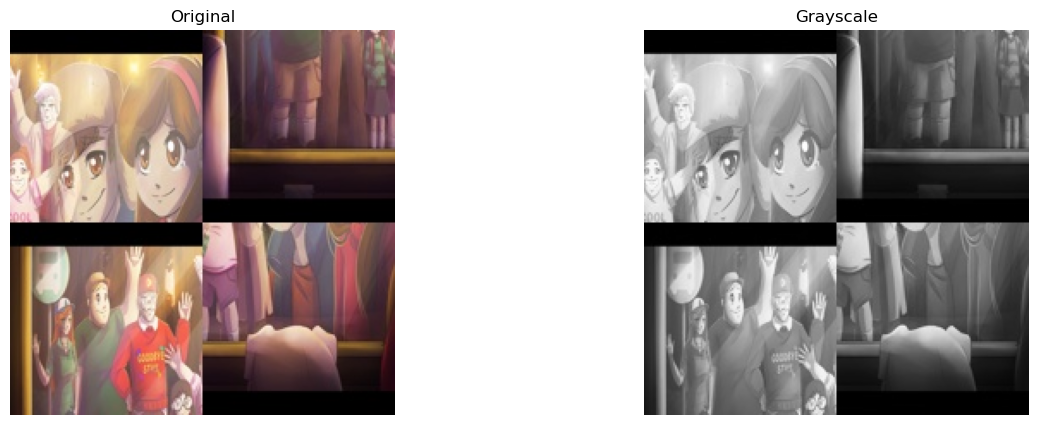

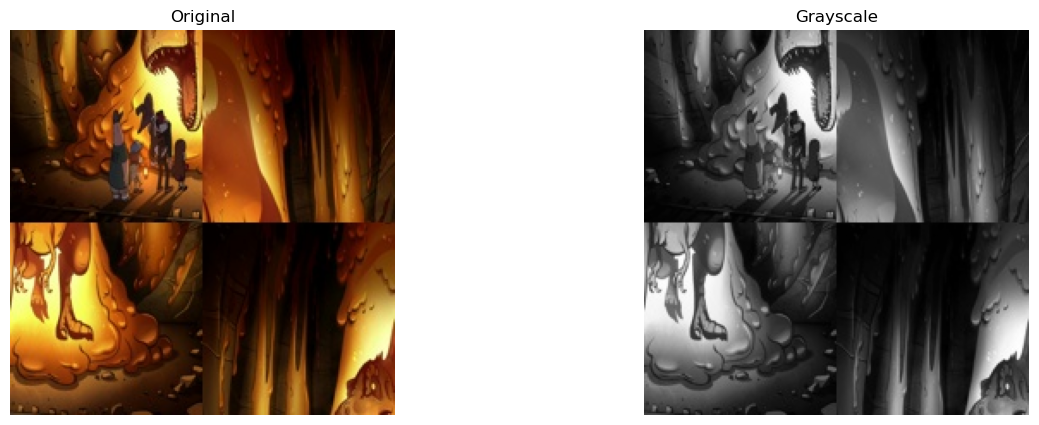

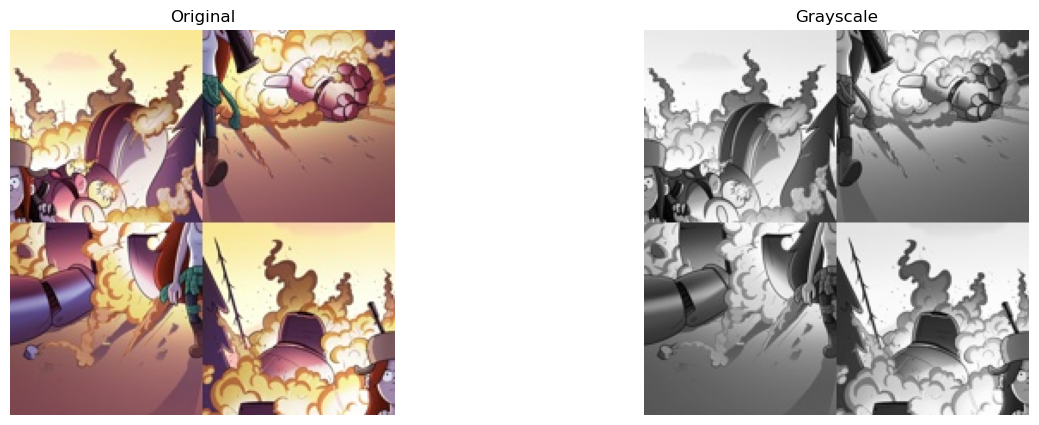

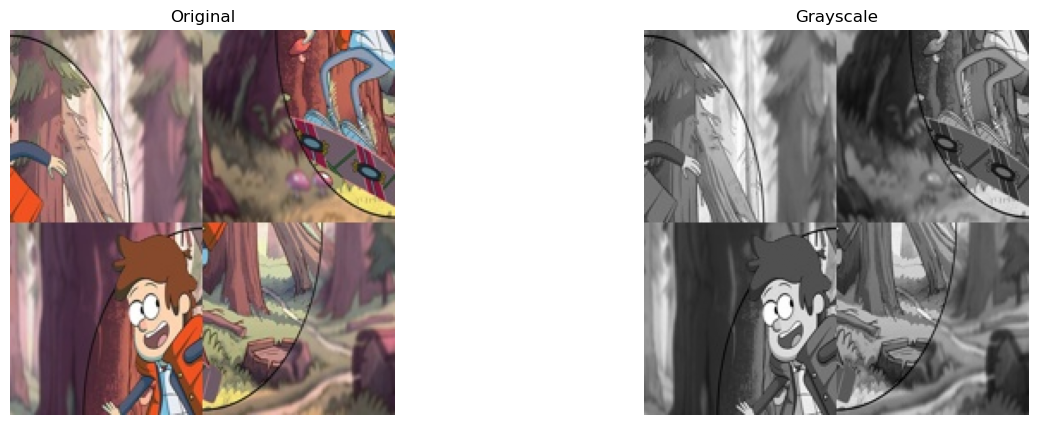

In [126]:
display_limit = 5
display_count = 0

for filename in files:
    img_path = os.path.join(puzzle_folder, filename)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read {filename}")
        continue

    gray = to_grayscale(img)
    
    # Save grayscale
    base_name = os.path.splitext(filename)[0]
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_grayscale.jpg"), gray)

    # Display only first 5 images
    if display_count < display_limit:
        show_images([img, gray], ["Original", "Grayscale"])
        display_count += 1


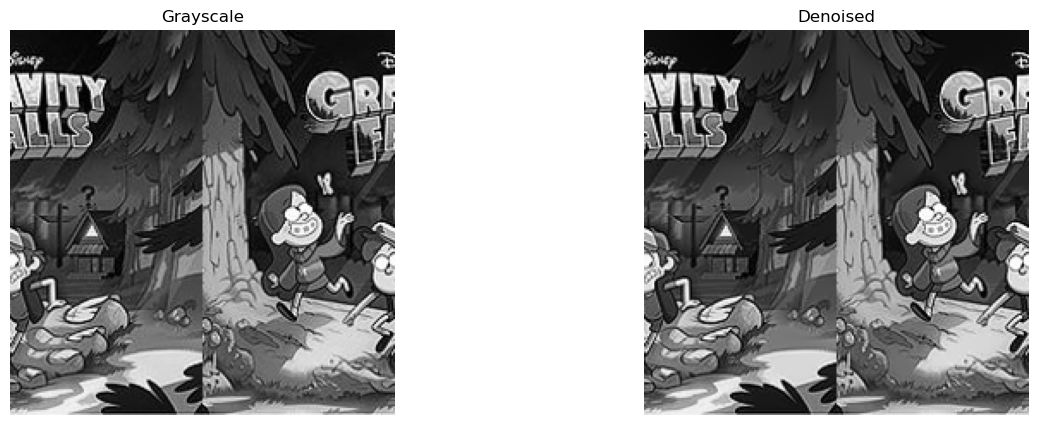

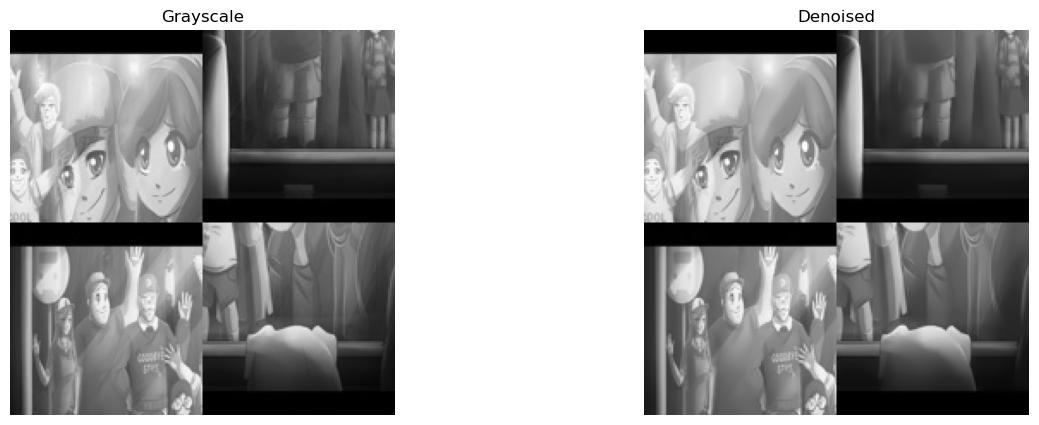

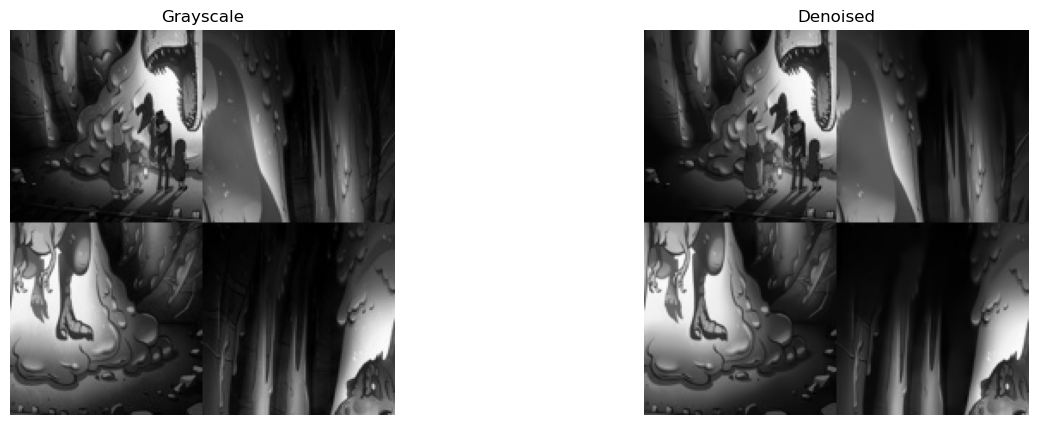

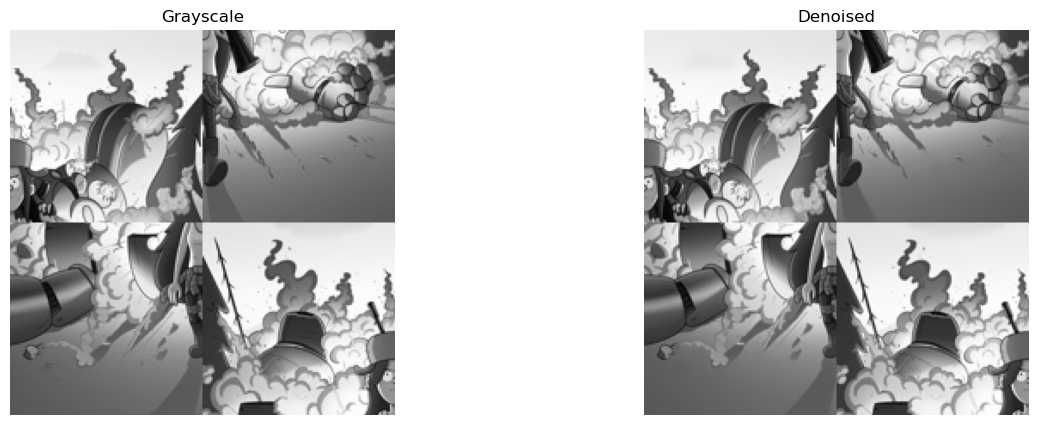

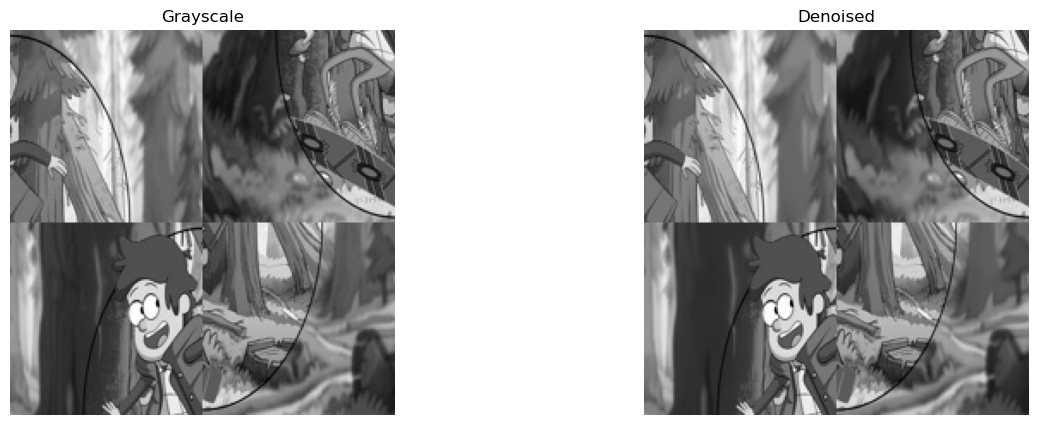

In [127]:
display_count = 0

for filename in files:
    base_name = os.path.splitext(filename)[0]
    gray_path = os.path.join(output_folder, f"{base_name}_grayscale.jpg")
    gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)

    denoised = denoise(gray_img)

    # Save denoised
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_denoised.jpg"), denoised)

    if display_count < display_limit:
        show_images([gray_img, denoised], ["Grayscale", "Denoised"])
        display_count += 1


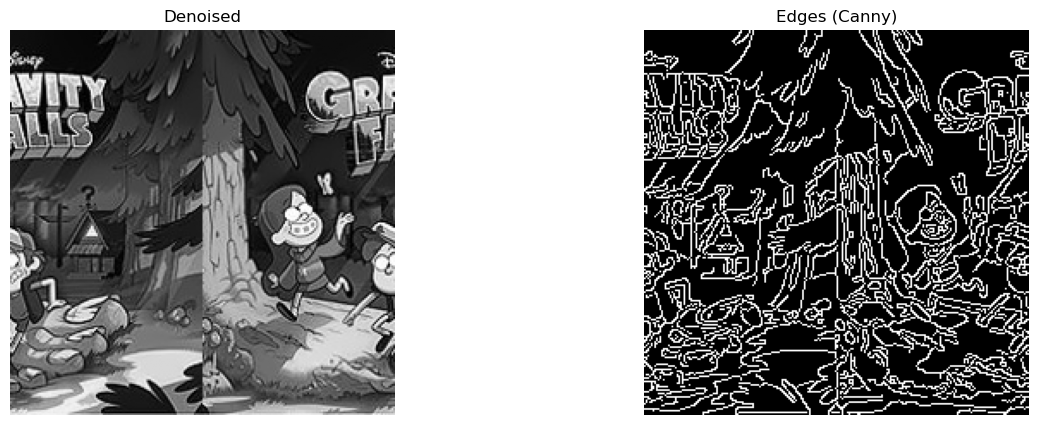

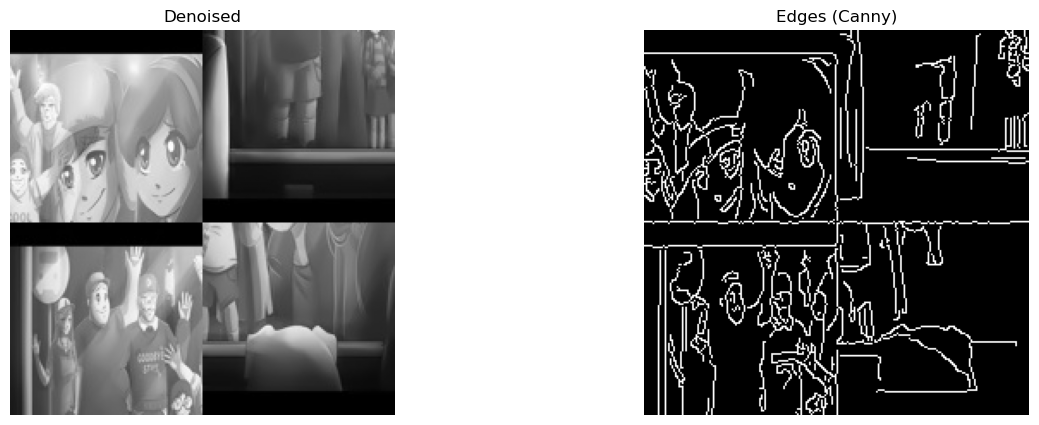

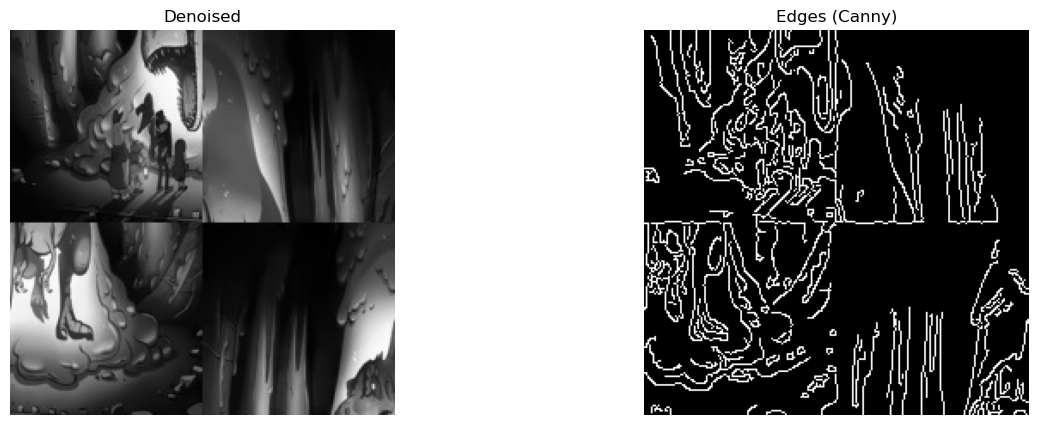

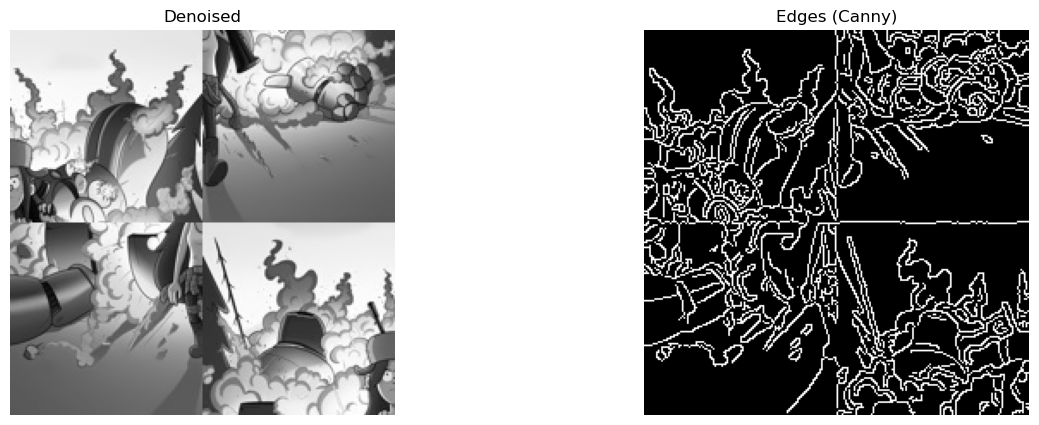

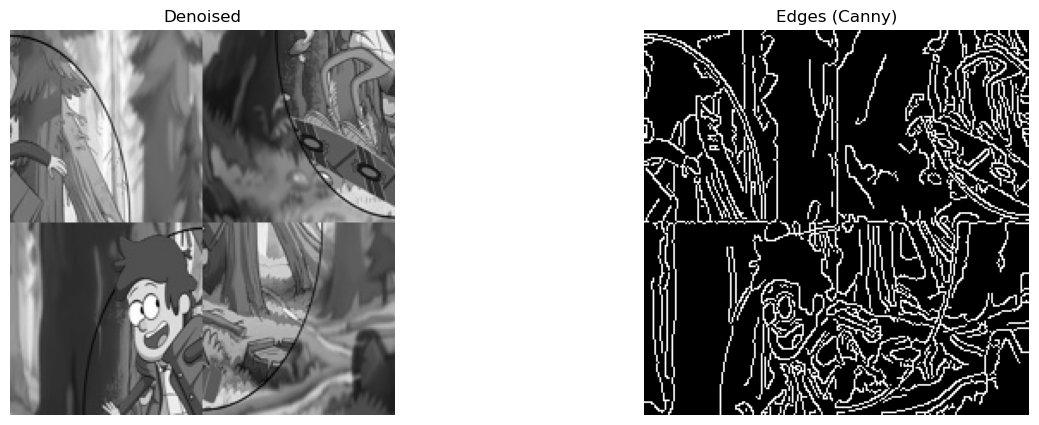

In [128]:
display_limit = 5
display_count = 0

for filename in files:
    base_name = os.path.splitext(filename)[0]
    
    # Read denoised image
    denoised_path = os.path.join(output_folder, f"{base_name}_denoised.jpg")
    denoised_img = cv2.imread(denoised_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply very light Gaussian blur (3x3) to slightly smooth noise
    blurred_img = cv2.GaussianBlur(denoised_img, (3, 3), 0)
    
    # Apply edge detection with adjusted thresholds
    edges = cv2.Canny(blurred_img, threshold1=50, threshold2=150, apertureSize=3)
    
    # Save edges
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_edges.jpg"), edges)
    
    # Display only first 5 images
    if display_count < display_limit:
        show_images([denoised_img, edges], ["Denoised", "Edges (Canny)"])
        display_count += 1


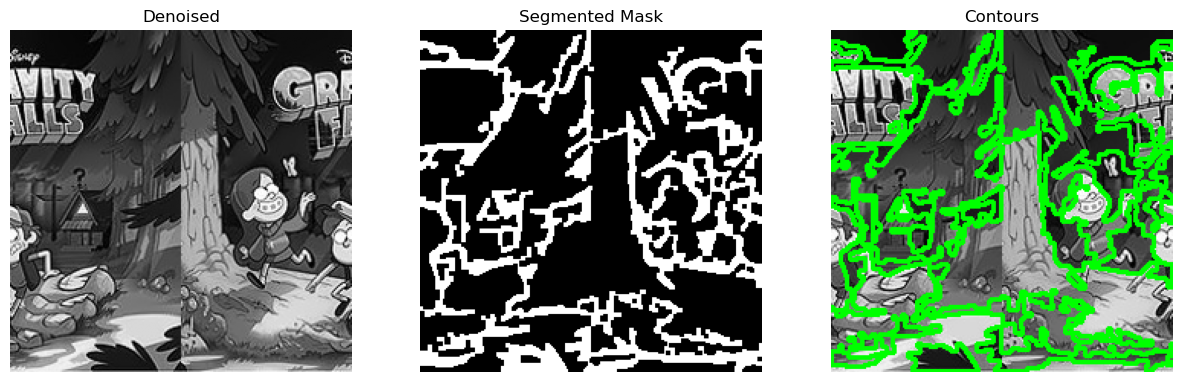

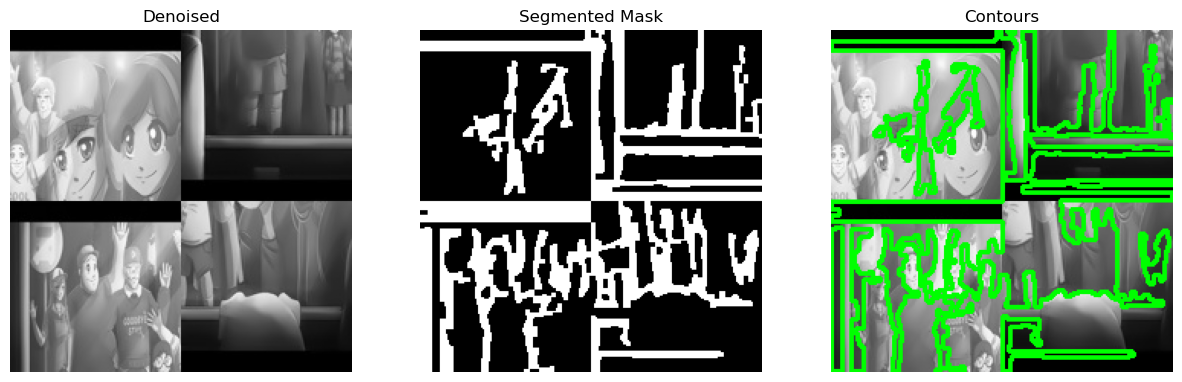

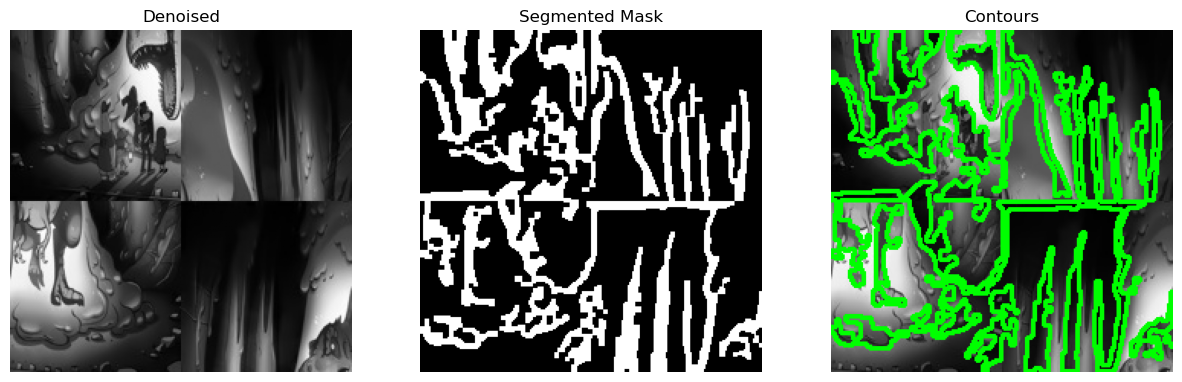

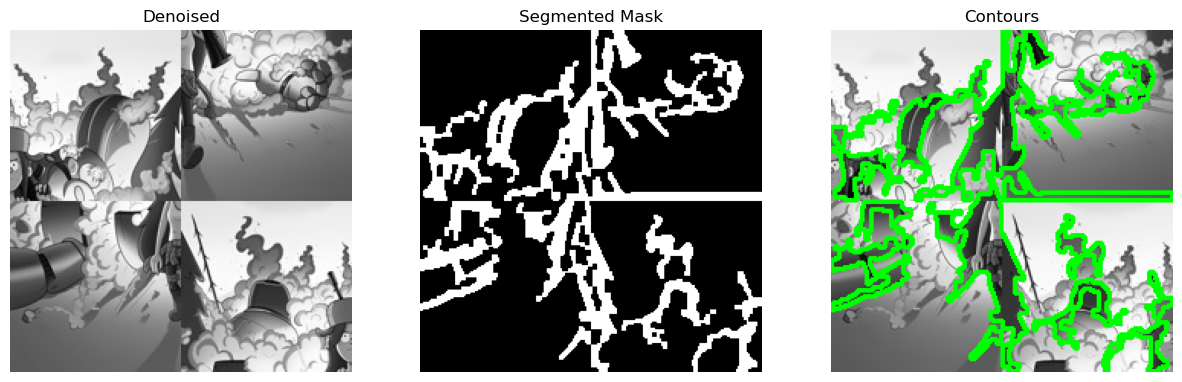

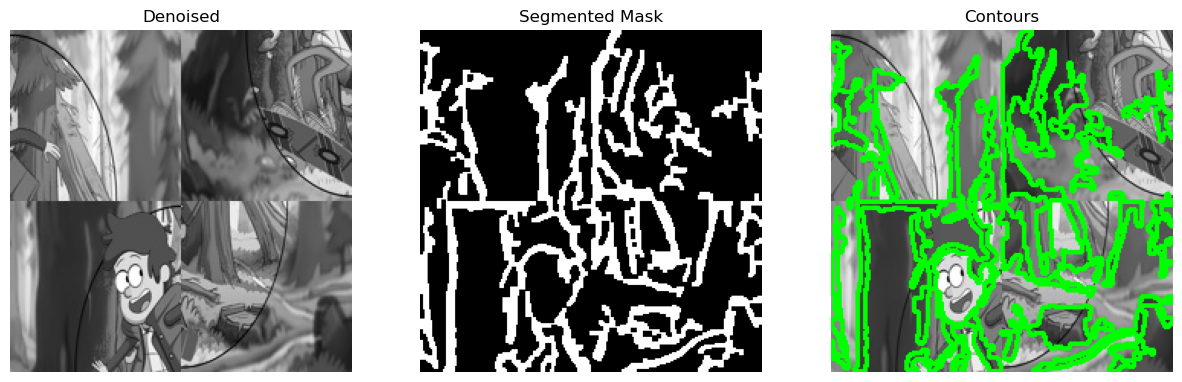

In [129]:
display_count = 0

for filename in files:
    base_name = os.path.splitext(filename)[0]
    denoised_path = os.path.join(output_folder, f"{base_name}_denoised.jpg")
    denoised_img = cv2.imread(denoised_path, cv2.IMREAD_GRAYSCALE)

    # Segment image and get contours
    binary_mask, contours = segment(denoised_img)

    # Save the binary segmented mask
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_segmented.jpg"), binary_mask)

    # Optional: visualize contours over the original image
    output = cv2.cvtColor(denoised_img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_segmented_contours.jpg"), output)

    # Display only first few images
    if display_count < display_limit:
        show_images([denoised_img, binary_mask, output], ["Denoised", "Segmented Mask", "Contours"])
        display_count += 1

